In [73]:

import warnings
import numpy as np
# import pandas as pd
import scanpy as sc
import scipy
from featuremap import featuremap_

sc.logging.print_header()
sc.settings.set_figure_params(dpi=120, facecolor='white')

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.4 numpy==1.23.5 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.2.2 statsmodels==0.14.0 igraph==0.11.4 louvain==0.8.0 pynndescent==0.5.11


# FeatureMAP on Pancreatic development data
1. GEX and GVA visualization
2. Gene variation trajectory and pseudotime
3. Core and transition states, leiden clustering implementation
4. DGV to indentify important genes
5. Gene contribution visualization


## Data loading


In [74]:

# Datasets
_datasets = {
    "pancreas": ("https://figshare.com/ndownloader/files/25060877", (2531, 27998)),
    "pancreas_preprocessed": ("https://figshare.com/ndownloader/files/25030028", (2531, 2000)),
    "pancreas_preprocessed_vk": ("https://figshare.com/ndownloader/files/41325411", (2531, 5974)),
    "lung": ("https://figshare.com/ndownloader/files/25038224", (24882, 24051)),
    "reprogramming_morris": ("https://figshare.com/ndownloader/files/25503773", (104679, 22630)),
    "zebrafish": ("https://figshare.com/ndownloader/files/27265280", (2434, 23974)),
    "reprogramming_schiebinger": ("https://figshare.com/ndownloader/files/28618734", (236285, 19089)),
    "reprogramming_schiebinger_serum_subset": ("https://figshare.com/ndownloader/files/35858033", (165892, 19089)),
    "bone_marrow": ("https://figshare.com/ndownloader/files/35826944", (5780, 27876)),
}

import os
dataset = 'pancreas'
filepath = f'datasets/{dataset}.h5ad'
# Check if the data is already downloaded
if not os.path.exists(filepath):
    print(f'Downloading {dataset} dataset...')
    # Download the preprocessed pancreas dataset
    adata = sc.read(filename=filepath, backup_url=_datasets[dataset][0])
else:
    adata = sc.read(filepath)

# import scvelo as scv
# scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000 )
    
# Preprocessing
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
# Highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]


In [75]:
adata

View of AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'n_genes'
    var: 'highly_variable_genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

## FeatureMAP GEX and GVA visualization

UMAP embedding.

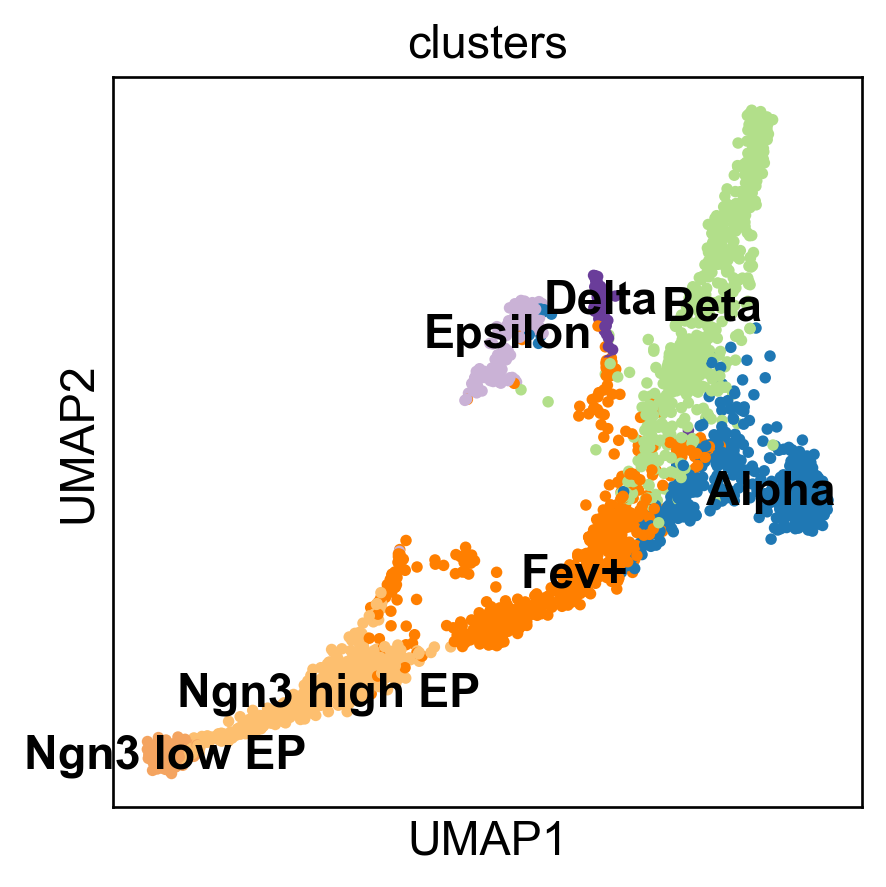

In [76]:
import umap
emb_umap = umap.UMAP().fit_transform(adata.X)
adata.obsm['X_umap'] = emb_umap
sc.pl.embedding(adata, basis='umap', color='clusters', legend_loc='on data')

### GEX embedding

In [77]:
 
import importlib
importlib.reload(featuremap_)

data = adata.X.copy()
emb_featuremap = featuremap_.FeatureMAP(
                    random_state=42,
                    output_variation=False,
                    output_feat=True,
                    # verbose=True,
                    ).fit(data)

/Users/uqyyao4/opt/anaconda3/envs/featmap/lib/python3.9/site-packages/numba/core/decorators.py:250: RuntimeWarning:

nopython is set for njit and is ignored

/Users/uqyyao4/Library/CloudStorage/OneDrive-TheUniversityofQueensland/project/FeatureMAP-1/featuremap/featuremap_.py:805: RuntimeWarning:

invalid value encountered in sqrt



mu is not added to adata


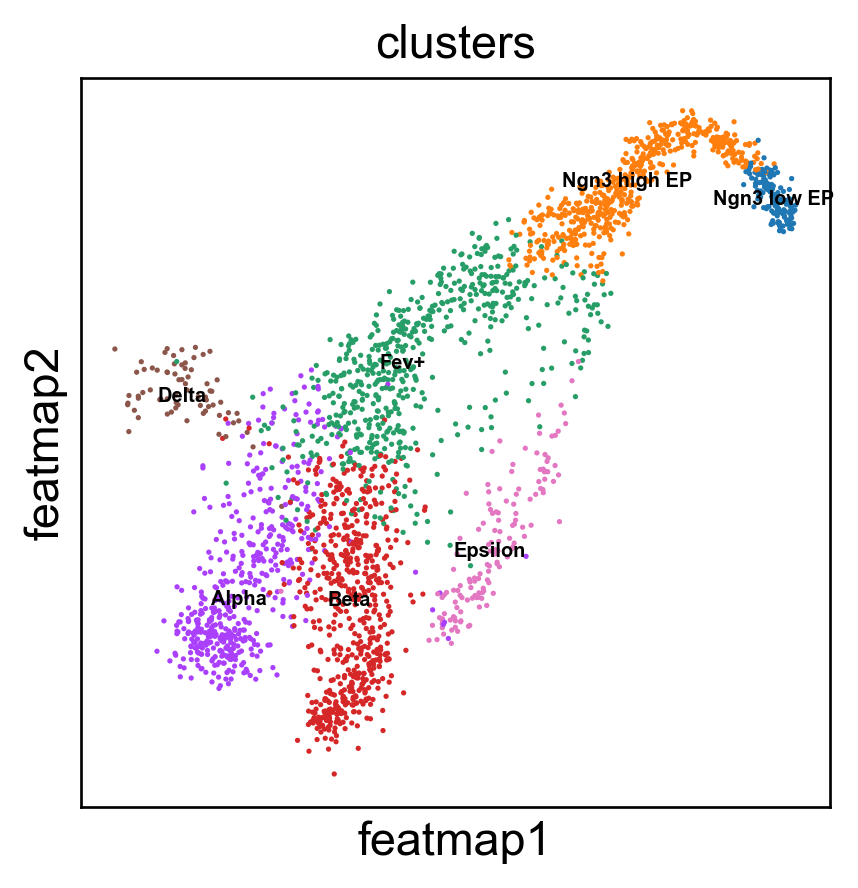

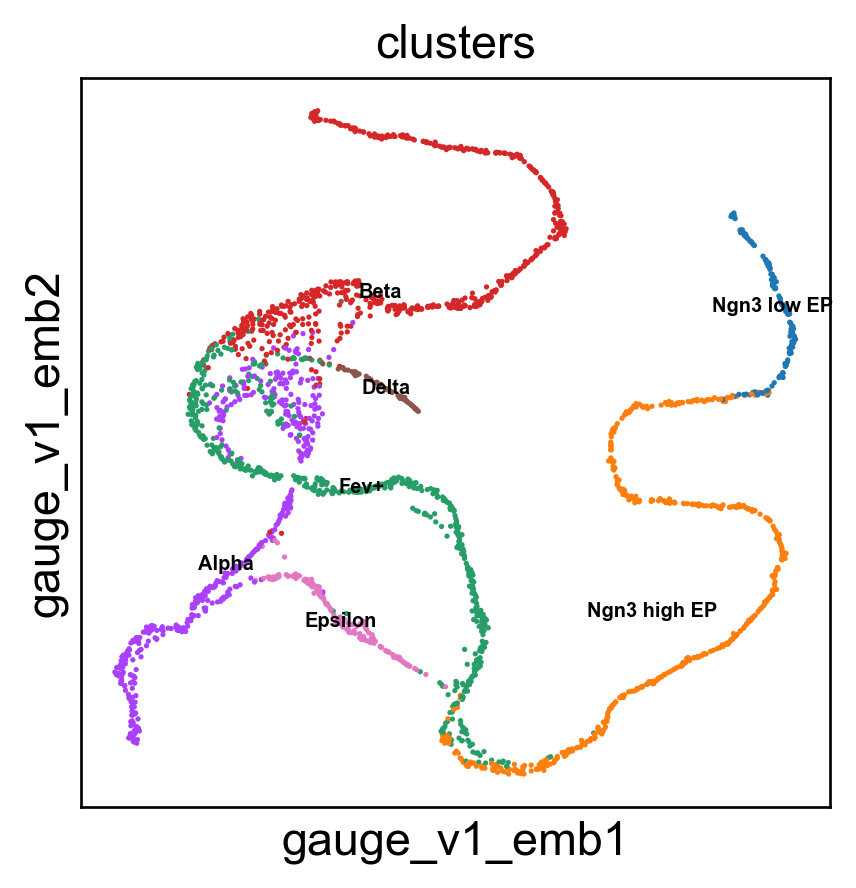

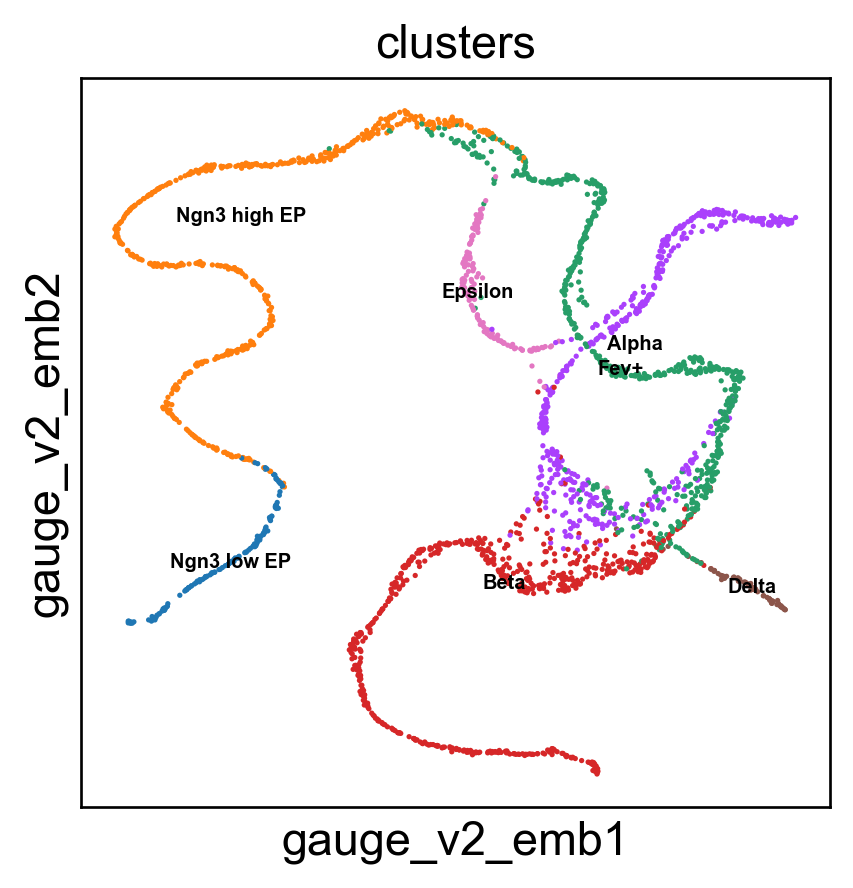

In [78]:
# create adata object
from featuremap import features
import importlib
importlib.reload(features)

adata = features.create_adata(X=data, emb_featuremap=emb_featuremap, obs=adata.obs, var=adata.var)

# adata.obsm['X_featmap'] = emb_featuremap.embedding_
# adata.obsm['gauge_v1_emb'] = emb_featuremap._featuremap_kwds['gauge_v1_emb']
# adata.obsm['gauge_v2_emb'] = emb_featuremap._featuremap_kwds['gauge_v2_emb']
# adata.obsm['vh_smoothed'] = emb_featuremap._featuremap_kwds['vh_smoothed']
# adata.obsm['Singular_value'] = emb_featuremap._featuremap_kwds['Singular_value']
# adata.varm['svd_vh'] = emb_featuremap._featuremap_kwds['svd_vh'].T
# adata.obsm['VH_embedding'] = emb_featuremap._featuremap_kwds['VH_embedding']

sc.pl.embedding(adata, 'featmap',legend_fontsize=6, s=10, legend_loc='on data', color=['clusters'])
sc.pl.embedding(adata, 'gauge_v1_emb',legend_fontsize =6, s=10,legend_loc='on data', color=['clusters'])
sc.pl.embedding(adata, 'gauge_v2_emb',legend_fontsize =6,s=10, legend_loc='on data', color=['clusters'])


In [79]:
adata

AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'n_genes'
    var: 'highly_variable_genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors'
    obsm: 'X_featmap', '_knn_indices', 'U', 'Singular_value', 'VH', 'vh_smoothed', 'gauge_v1_emb', 'gauge_v2_emb', 'VH_embedding', 'R', 'mu_sum', 're_sum', 're_sum_without_log', 'emb_knn_indices', 'X_embedding'
    varm: 'svd_vh'

### GVA embedding

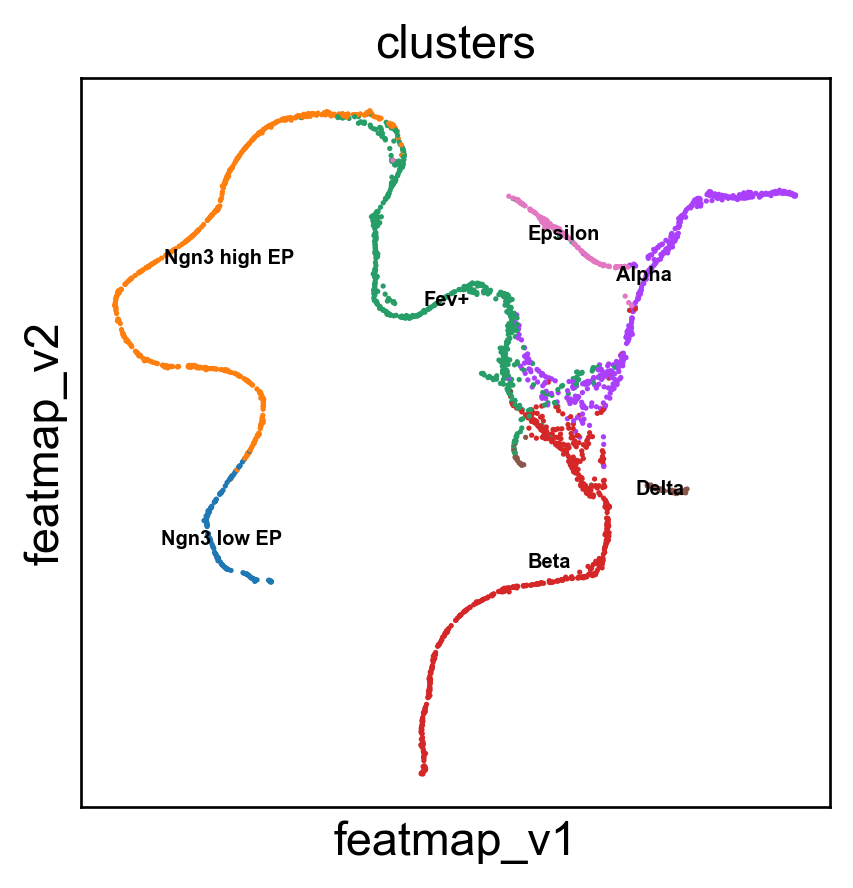

In [80]:
# Variation embedding
import importlib
importlib.reload(featuremap_)
data = adata.X.copy()
emb_featuremap = featuremap_.FeatureMAP(random_state=42,output_variation=True,threshold=0.5, min_dist=0.3).fit(data)

adata.obsm['X_featmap_v'] = emb_featuremap.embedding_
sc.pl.embedding(adata, 'featmap_v',legend_fontsize=6, s=10, legend_loc='on data', color=['clusters'])

adata.obsm['variation_pc'] = emb_featuremap._featuremap_kwds['variation_pc']


3D embedding

In [81]:
data = adata.X.copy()
from featuremap import featuremap_
emb_featuremap_3d = featuremap_.FeatureMAP(n_components=3,random_state=42,output_variation=True,).fit_transform(data)

adata.obsm['X_featmap_v_3d'] = emb_featuremap_3d


In [82]:



from featuremap import features
import importlib
importlib.reload(features)

features.featuremap_var_3d(emb_featuremap_3d, color=adata.obs['clusters'])

Pseudotime.

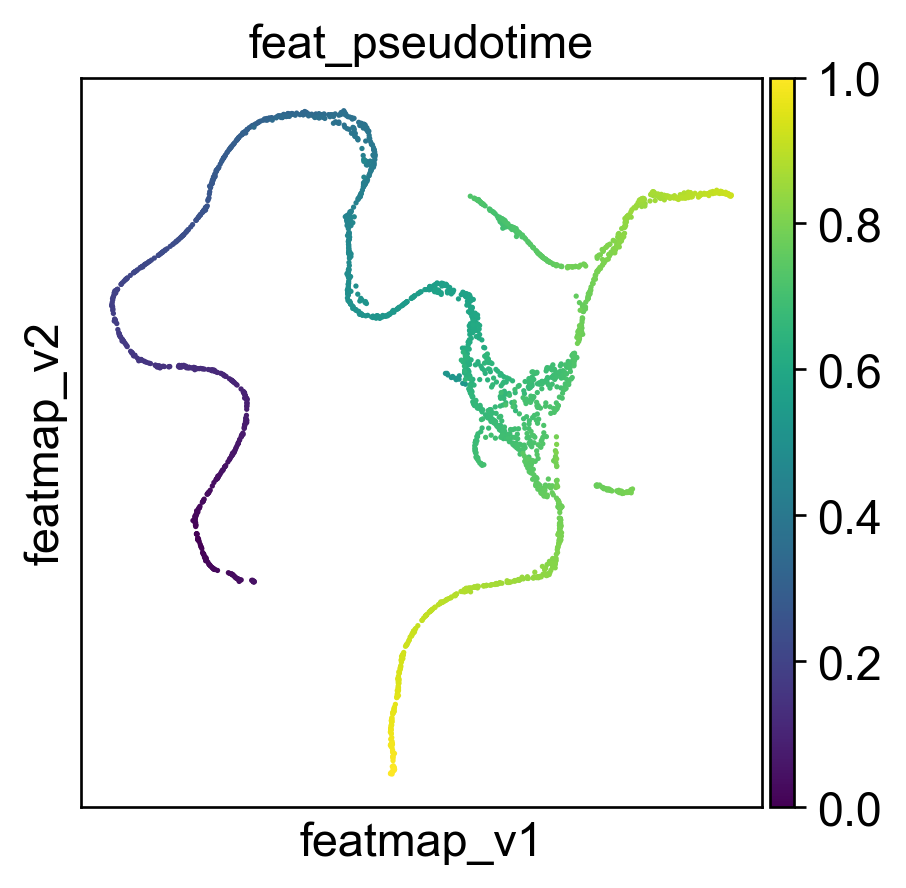

In [84]:
# FeatureMAP pseudo-time
from featuremap import features
import importlib
importlib.reload(features)

# Starting point index
# Randomly select a starting point from cluster "Ng3 low EP"
start_point_index = np.where(adata.obs['clusters'] == 'Ngn3 low EP')[0][0]
features.pseudotime_mst(adata, random_state=42, start_point_index=start_point_index)

sc.pl.embedding(adata, 'featmap_v',legend_fontsize=10, s=10, color=['feat_pseudotime'])

## Core and transition states

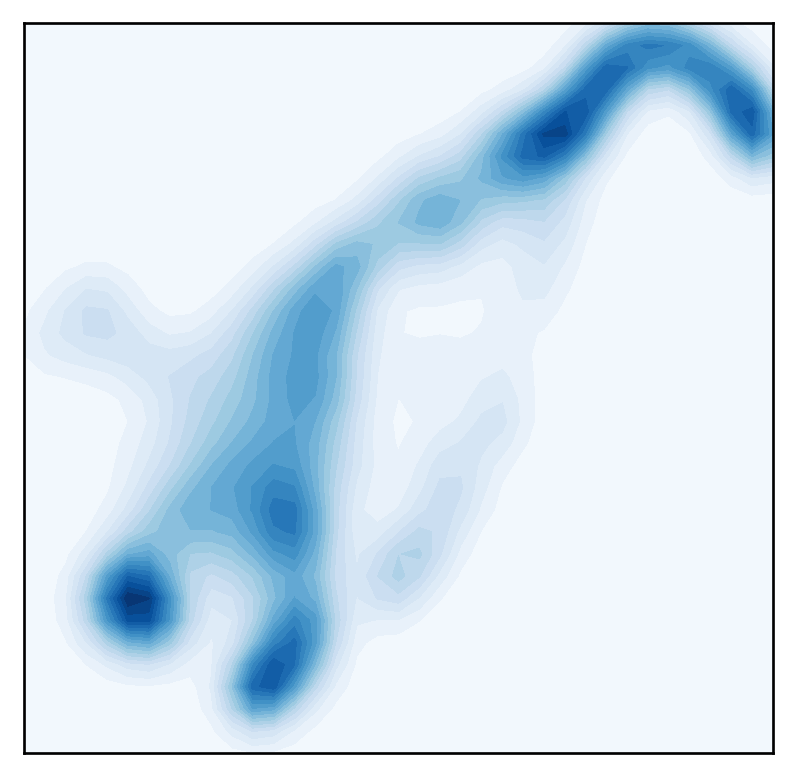

<Figure size 480x480 with 0 Axes>

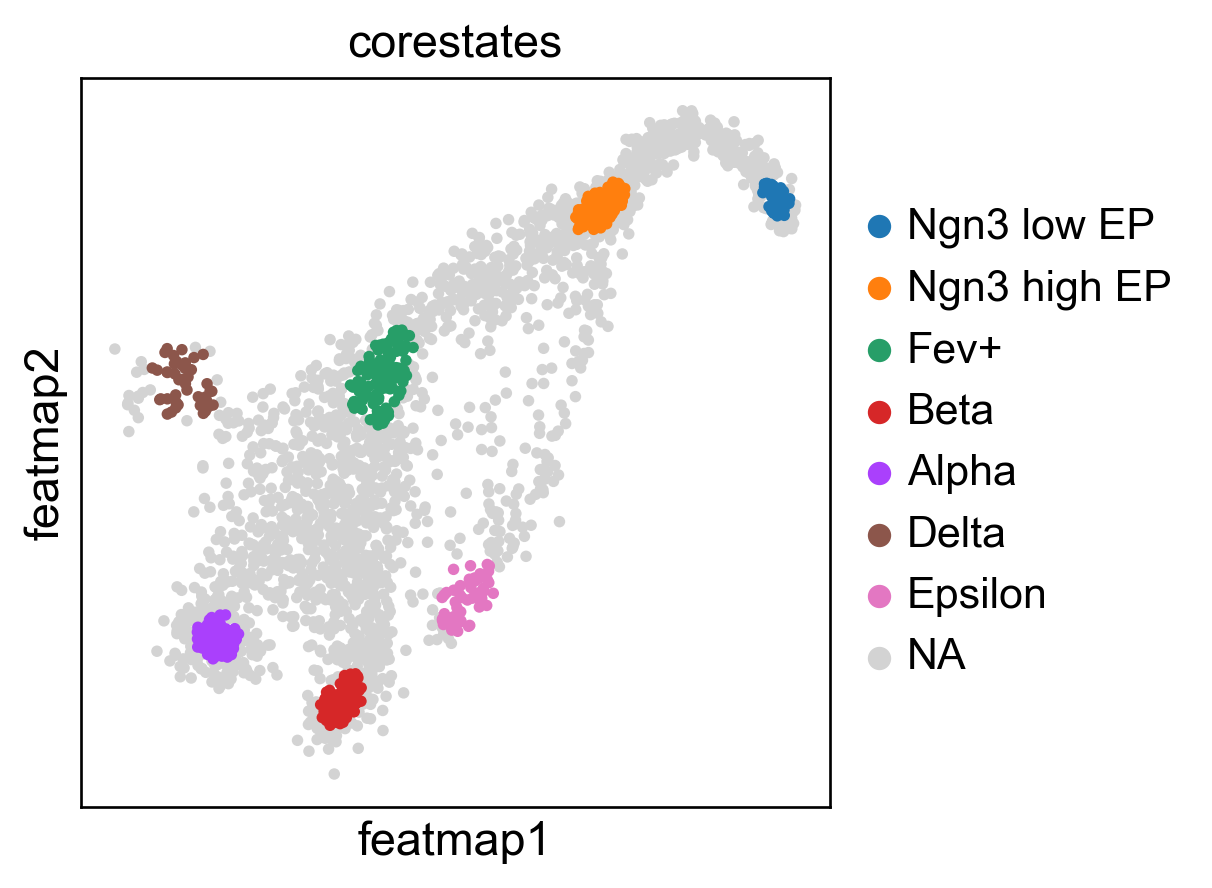

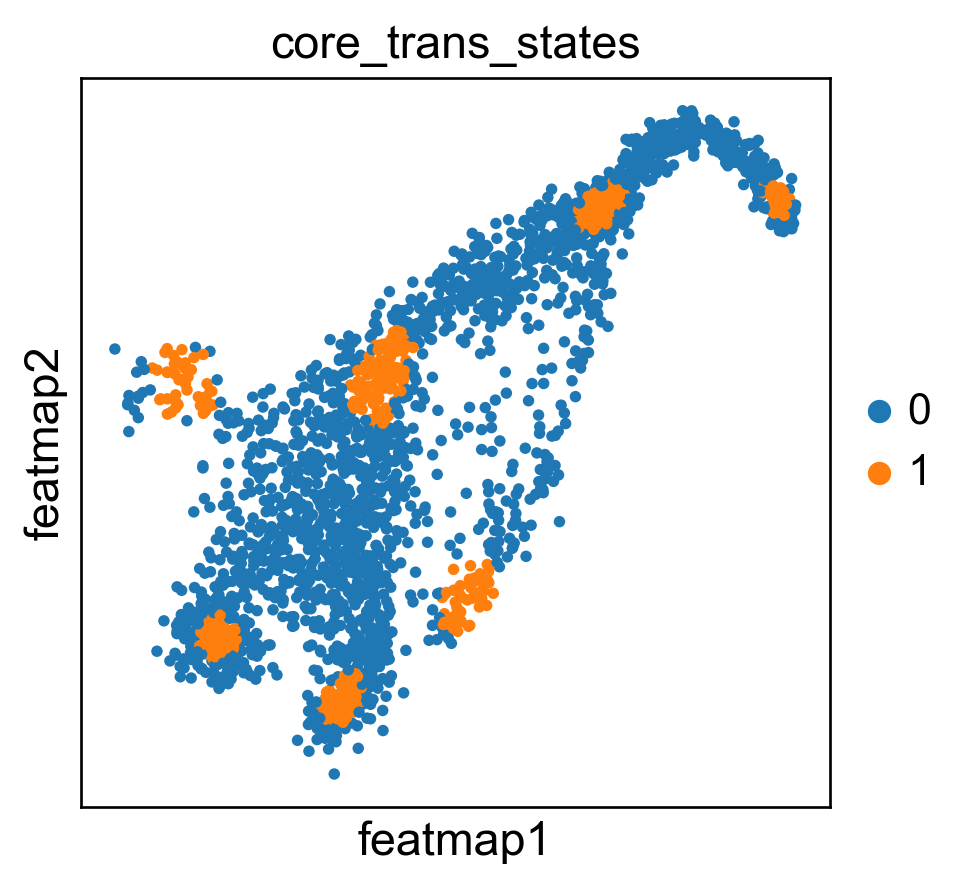

In [106]:
# Contour plot to show the density

from featuremap import core_transition_state
import importlib
importlib.reload(core_transition_state)

# Plot the density 
core_transition_state.plot_density(adata)

# Compute core-states based on clusters
core_transition_state.core_transition_state(adata)

Project core and transition states to GVA embedding.

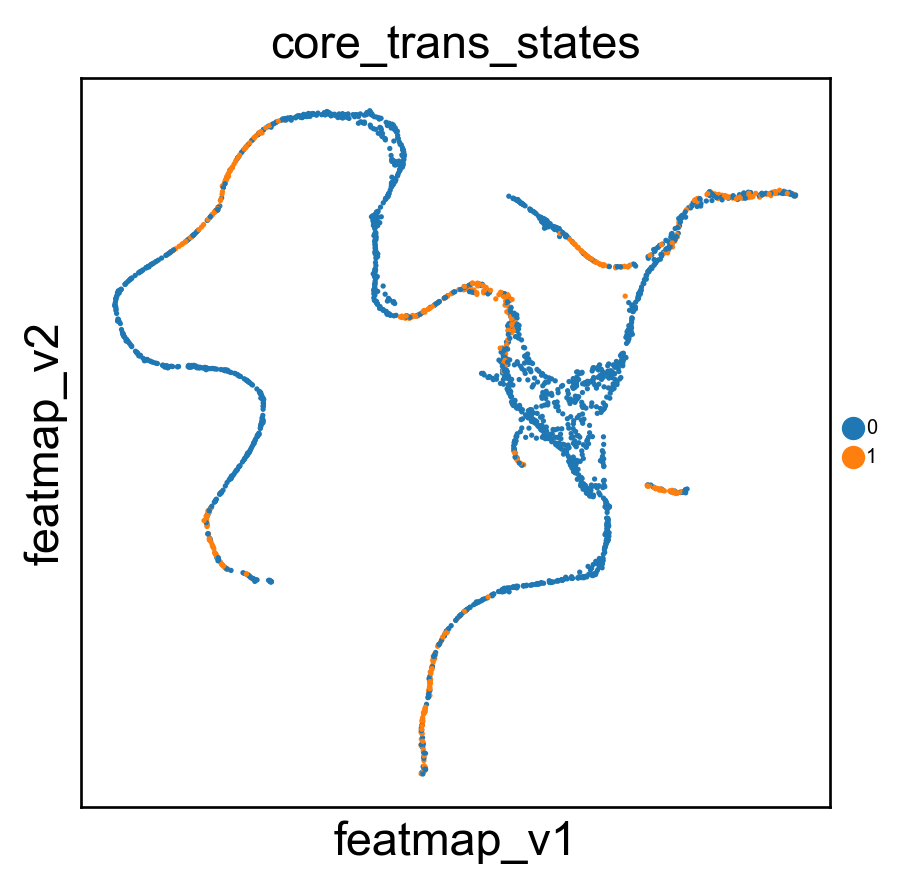

In [107]:
# plot core/transition states on variation embedding
sc.pl.embedding(adata, 'featmap_v',legend_fontsize =6, s=10, color=['core_trans_states'])

In [108]:
adata

AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'n_genes', 'feat_pseudotime', 'density', 'density_separate_cluster', 'corestates', 'corestates_largest', 'corestates_binary', 'corestates_points', 'core_trans_states', 'cell_variation', 'leiden_v', 'core_trans_states_bifur', 'path_states', 'intrinsic_dim'
    var: 'highly_variable_genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'corestates_colors', 'core_trans_states_colors', 'leiden_v_colors', 'core_trans_states_bifur_colors', 'path_states_colors'
    obsm: 'X_featmap', '_knn_indices', 'U', 'Singular_value', 'VH', 'vh_smoothed', 'gauge_v1_emb', 'gauge_v2_emb', 'VH_embedding', 'R', 'mu_sum', 're_sum', 're_sum_without_log', 'emb_knn_indices', 'X_embedding', 'X_featmap_v', 'variation_pc', 'X_featmap_v_3d'
    var

In [109]:
emb_featuremap_3d = adata.obsm['X_featmap_v_3d']
features.featuremap_var_3d(emb_featuremap_3d, color=adata.obs['core_trans_states'], marker_size=1)

In [110]:
adata

AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'n_genes', 'feat_pseudotime', 'density', 'density_separate_cluster', 'corestates', 'corestates_largest', 'corestates_binary', 'corestates_points', 'core_trans_states', 'cell_variation', 'leiden_v', 'core_trans_states_bifur', 'path_states', 'intrinsic_dim'
    var: 'highly_variable_genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'corestates_colors', 'core_trans_states_colors', 'leiden_v_colors', 'core_trans_states_bifur_colors', 'path_states_colors'
    obsm: 'X_featmap', '_knn_indices', 'U', 'Singular_value', 'VH', 'vh_smoothed', 'gauge_v1_emb', 'gauge_v2_emb', 'VH_embedding', 'R', 'mu_sum', 're_sum', 're_sum_without_log', 'emb_knn_indices', 'X_embedding', 'X_featmap_v', 'variation_pc', 'X_featmap_v_3d'
    var

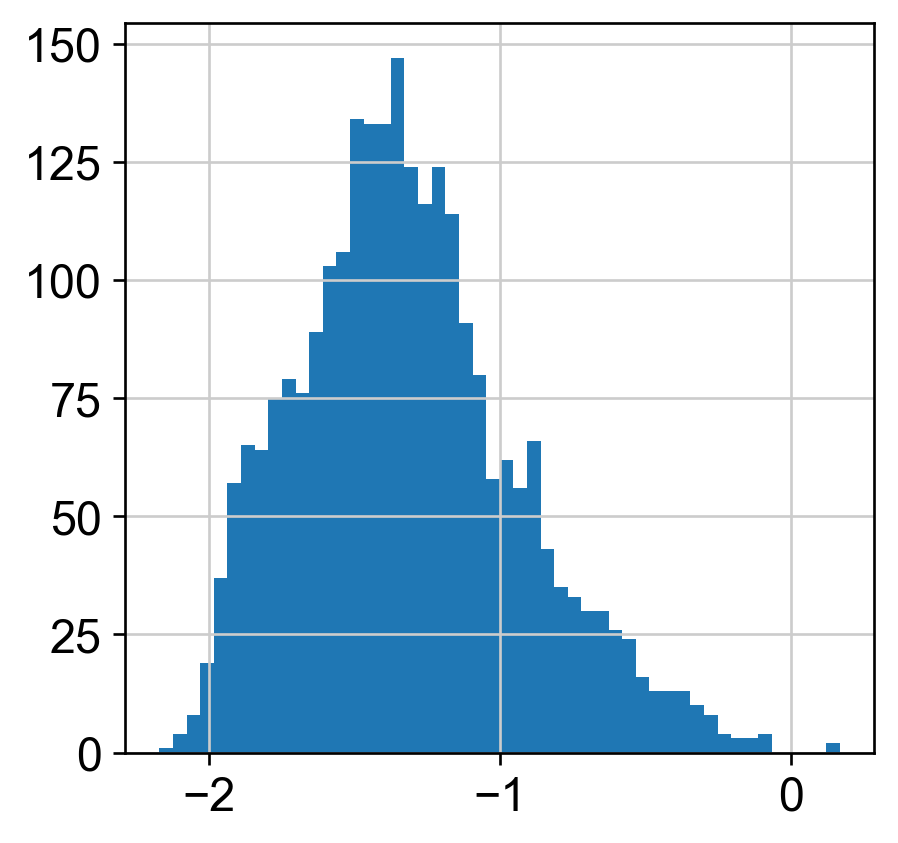

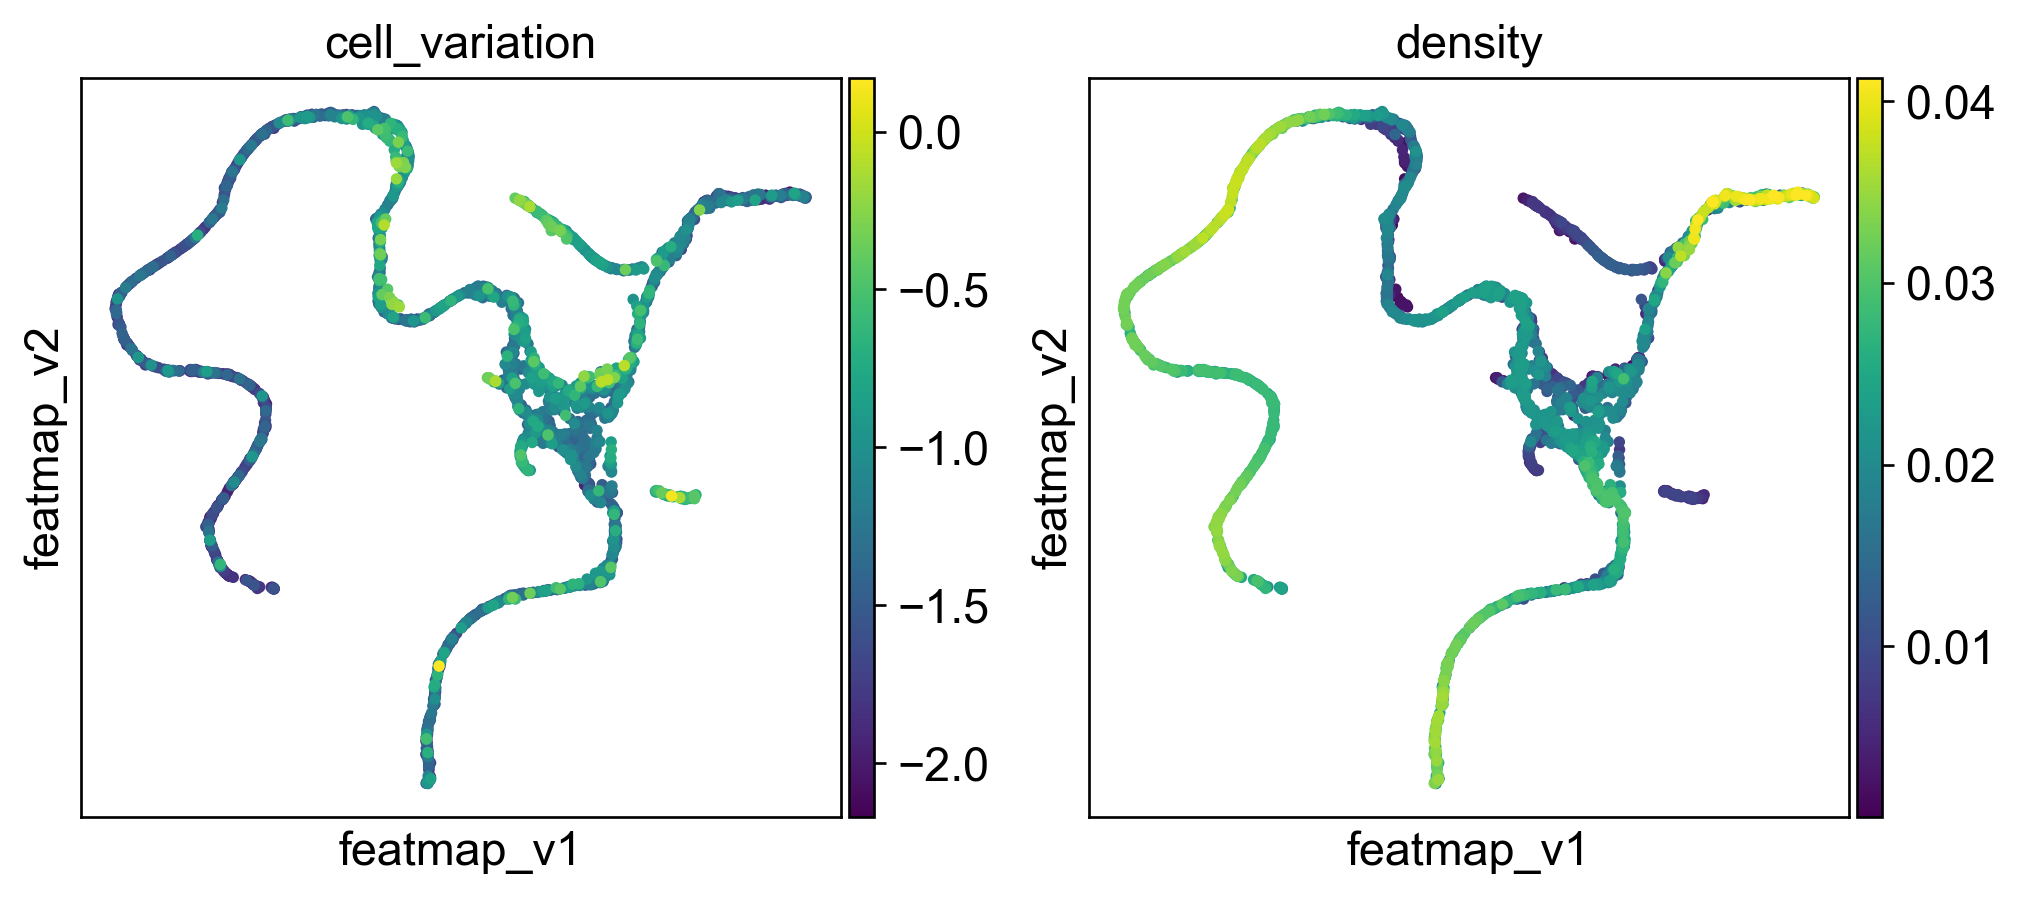

In [111]:
"""
Cell variation
"""
#######################################################
# use singular values to represent the variation
############################################################
# singular_val = emb_featuremap._featuremap_kwds['Singular_value']
# singular_val = emb_featuremap._featuremap_kwds['R']
singular_val = adata.obsm['re_sum_without_log']

# norm of the top k singular values
k=10
singular_val_norm = np.linalg.norm(singular_val[:,:k], axis=1)
singular_val_norm = np.log(singular_val_norm)
# plt.hist(singular_val_norm, bins=50)
import matplotlib.pyplot as plt
plt.hist(singular_val_norm, bins=50)

adata.obs['cell_variation'] = singular_val_norm
sc.pl.embedding(adata, 'featmap_v', legend_loc='on data' , legend_fontsize=10,color=['cell_variation', 'density',])

In [112]:

############################################
# Density vs pseudotime
############################################
#%%
def plot_density_pseudotime(filtered_data, pseudotime='feat_pseudotime', clusters='clusters', density='density'):
    from pygam import LinearGAM
    import seaborn as sns
    import matplotlib.pyplot as plt

    X = filtered_data[pseudotime].values
    y = filtered_data[density].values
    gam = LinearGAM(n_splines=20).fit(X, y)
    
    fig, ax = plt.subplots()
    XX = gam.generate_X_grid(term=0, n=100)
   
    for response in gam.sample(X, y, quantity='y', n_draws=50, sample_at_X=XX):
        plt.scatter(XX, response, alpha=.01, color='k')
    plt.plot(XX, gam.predict(XX), 'r--')
    plt.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')

    ax.plot(XX, gam.predict(XX), 'b--', label='_nolegend_')
    sns.scatterplot(x=pseudotime, y=density, data=filtered_data, hue=clusters, ax=ax)
    

    ax.set_xlabel(pseudotime)
    # ax.set_ylabel('')
    ax.set_ylabel(density)
    ax.legend().remove()
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.savefig(f'./figures/pancreas/density_pseudotime_{pseudotime}_beta.png', bbox_inches='tight')
    plt.show()


In [113]:
adata

AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'n_genes', 'feat_pseudotime', 'density', 'density_separate_cluster', 'corestates', 'corestates_largest', 'corestates_binary', 'corestates_points', 'core_trans_states', 'cell_variation', 'leiden_v', 'core_trans_states_bifur', 'path_states', 'intrinsic_dim'
    var: 'highly_variable_genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'corestates_colors', 'core_trans_states_colors', 'leiden_v_colors', 'core_trans_states_bifur_colors', 'path_states_colors'
    obsm: 'X_featmap', '_knn_indices', 'U', 'Singular_value', 'VH', 'vh_smoothed', 'gauge_v1_emb', 'gauge_v2_emb', 'VH_embedding', 'R', 'mu_sum', 're_sum', 're_sum_without_log', 'emb_knn_indices', 'X_embedding', 'X_featmap_v', 'variation_pc', 'X_featmap_v_3d'
    var

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |#######################

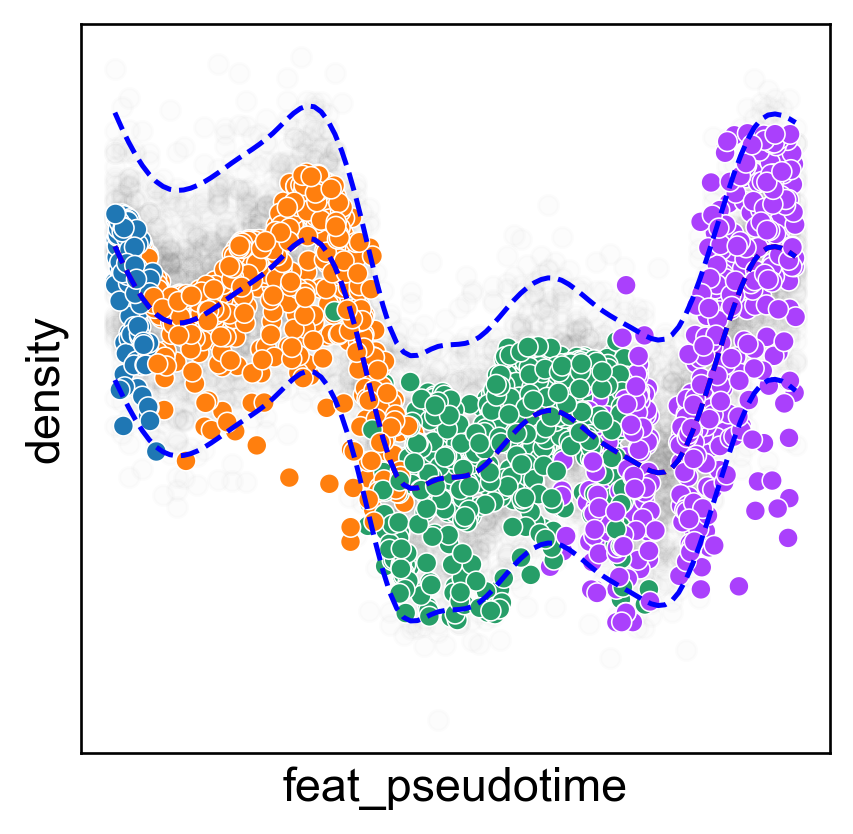

In [114]:
#%%
# Filter cells based on clusters

selected_clusters = ['Ngn3 low EP', 'Ngn3 high EP', 'Fev+', 'Alpha']
# selected_clusters = ['Ngn3 low EP', 'Ngn3 high EP', 'Fev+', 'Beta']
# selected_clusters = ['Fev+', 'Beta']
# selected_clusters = ['Fev+', 'Alpha']


# selected_clusters = ['Exh-Int', 'Exh-KLR']
# selected_clusters = ['Fev+', 'Alpha']
filtered_data = adata.obs[adata.obs['clusters'].isin(selected_clusters)]
# downsample the data to 350 cells
# filtered_data = filtered_data.sample(n=350, random_state=42)
# Filter data with density larger than 0.02
# filtered_data = filtered_data[filtered_data['density'] > 0.03]
#%%
# Denstiy vs pseudotime
# pseudotime_list = ['feat_pseudotime','dpt_pseudotime', 'palantir_pseudotime', 'slingshot_pseudotime', 'monocle2_pseudotime', 
                #    'monocle3_pseudotime',  'scFate_pseudotime', 'via_pseudotime']
# for pseudotime in pseudotime_list:
plot_density_pseudotime(filtered_data, pseudotime='feat_pseudotime', density='density', clusters='clusters')

Leiden clustering to refine the core and transition states.

In [115]:
import anndata as ad
adata_var = ad.AnnData(X=adata.obsm['variation_pc'], obs=adata.obs)
adata_var.obsm['X_featmap_v'] = adata.obsm['X_featmap_v']
adata_var.obs['clusters'] = adata.obs['clusters']

# leiiden clustering on variation embedding
sc.pp.pca(adata_var)
sc.pp.neighbors(adata_var, n_neighbors=5,)
sc.tl.leiden(adata_var, resolution=0.5)

adata.obs['leiden_v'] = adata_var.obs['leiden']


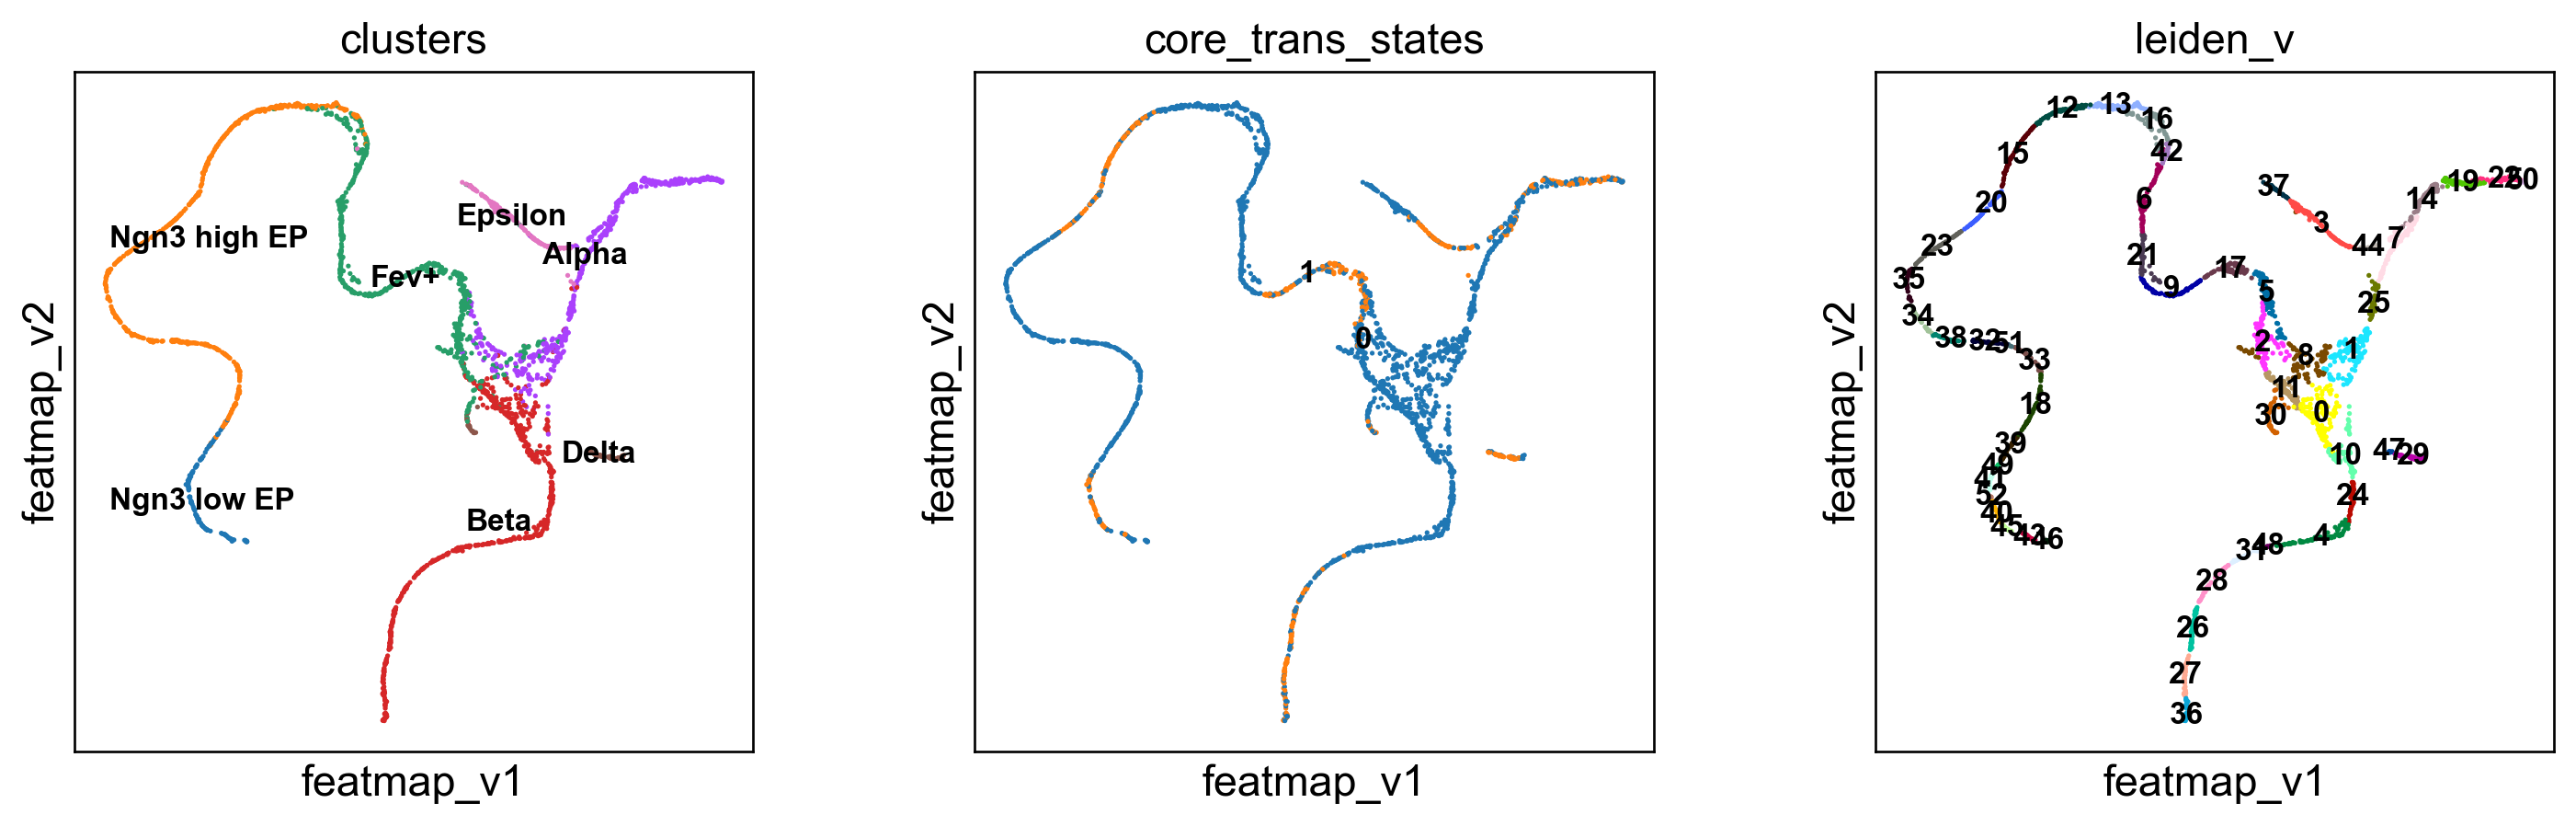

In [116]:
#  plot the density
sc.settings.set_figure_params(dpi=120)

sc.pl.embedding(adata, 'featmap_v',legend_fontsize=10, s=10, legend_loc='on data', 
                color=['clusters','core_trans_states', 'leiden_v'])

In [117]:
import importlib
importlib.reload(features)

# features.featuremap_var_3d(emb_featuremap_3d, color=adata.obs['clusters'], marker_size=3)
features.featuremap_var_3d(emb_featuremap_3d, color=adata.obs['leiden_v'], symbol=adata.obs['clusters'], marker_size=1)

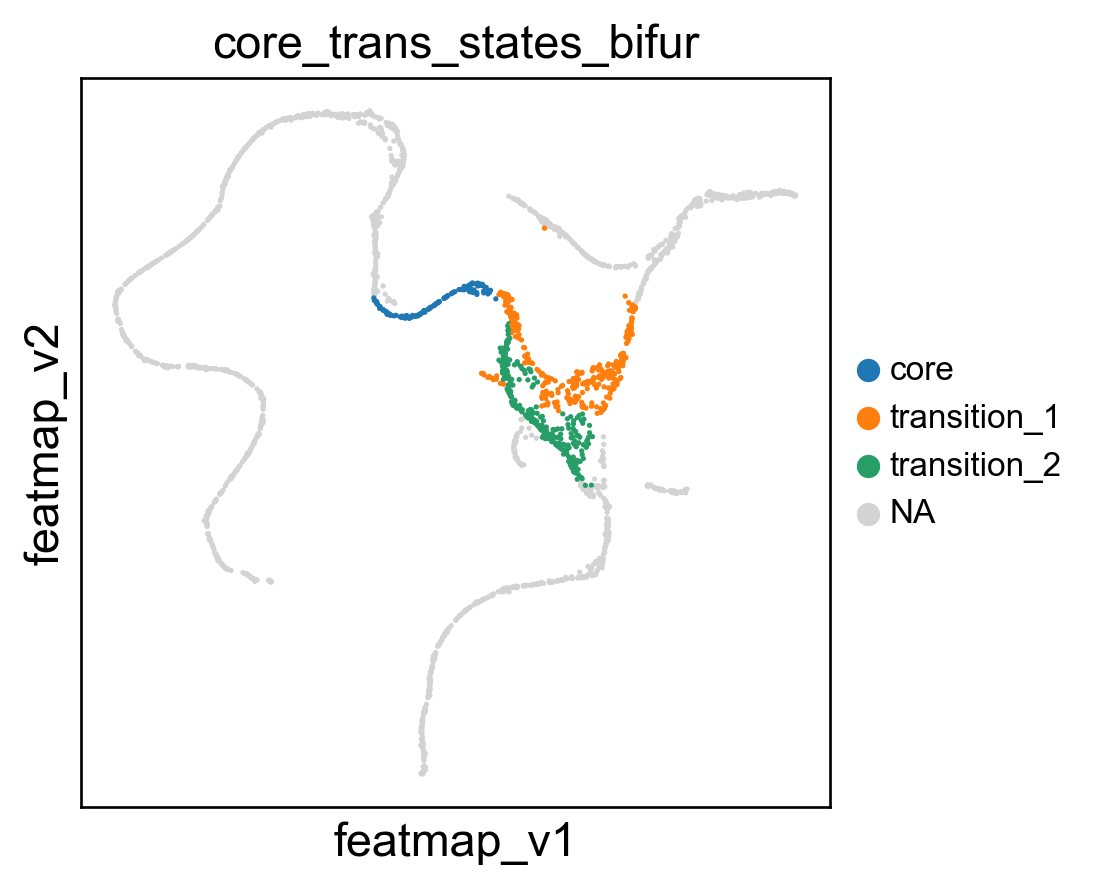

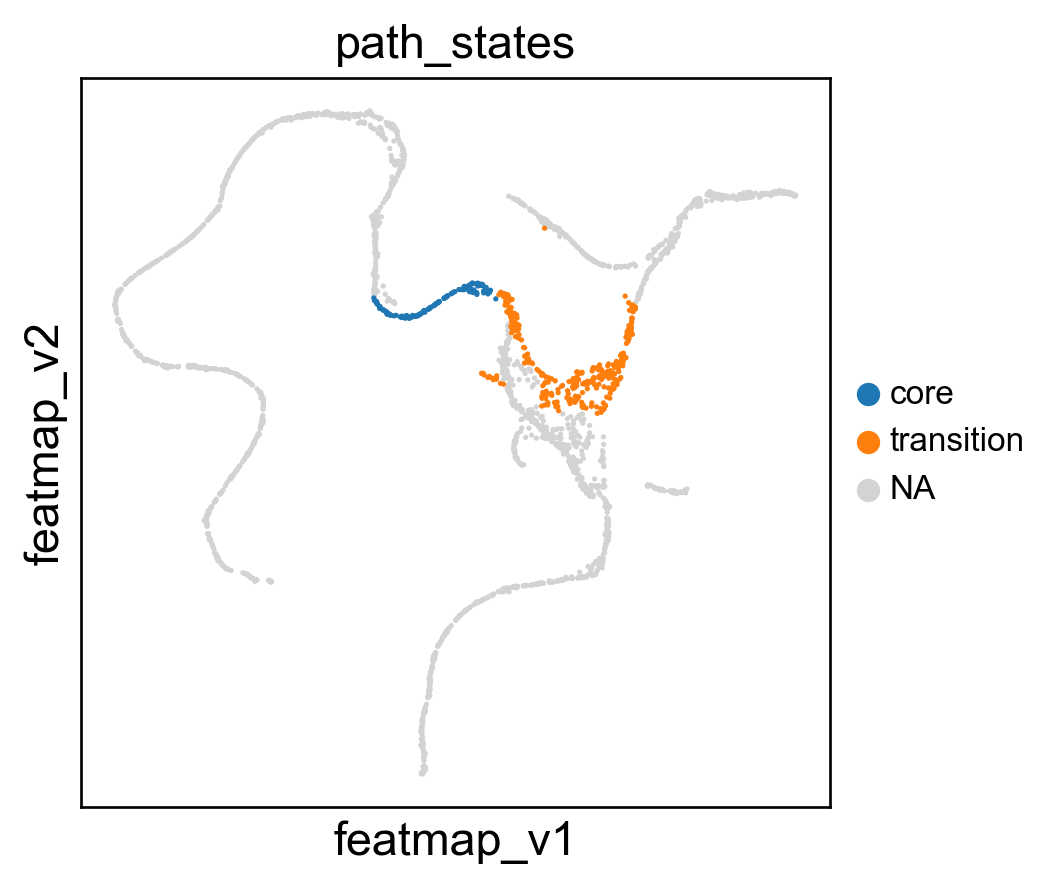

In [118]:

# During the bifurcation, select the core states and transition states by leiiden clustering
core_states = [9,17,]
transition_states_1 = [5, 8,1,25]
transition_states_2 = [2,11,0]


from featuremap import core_transition_state
import importlib
importlib.reload(core_transition_state)

core_transition_state.bifurcation_plot(adata, core_states, transition_states_1, transition_states_2)
core_transition_state.path_plot(adata, core_states, transition_states_1)




T-test p-value for core states and transition states_1: 2.515179499666978e-07


Text(0.5, 1.0, 'T-test p-value is 2.515e-07')

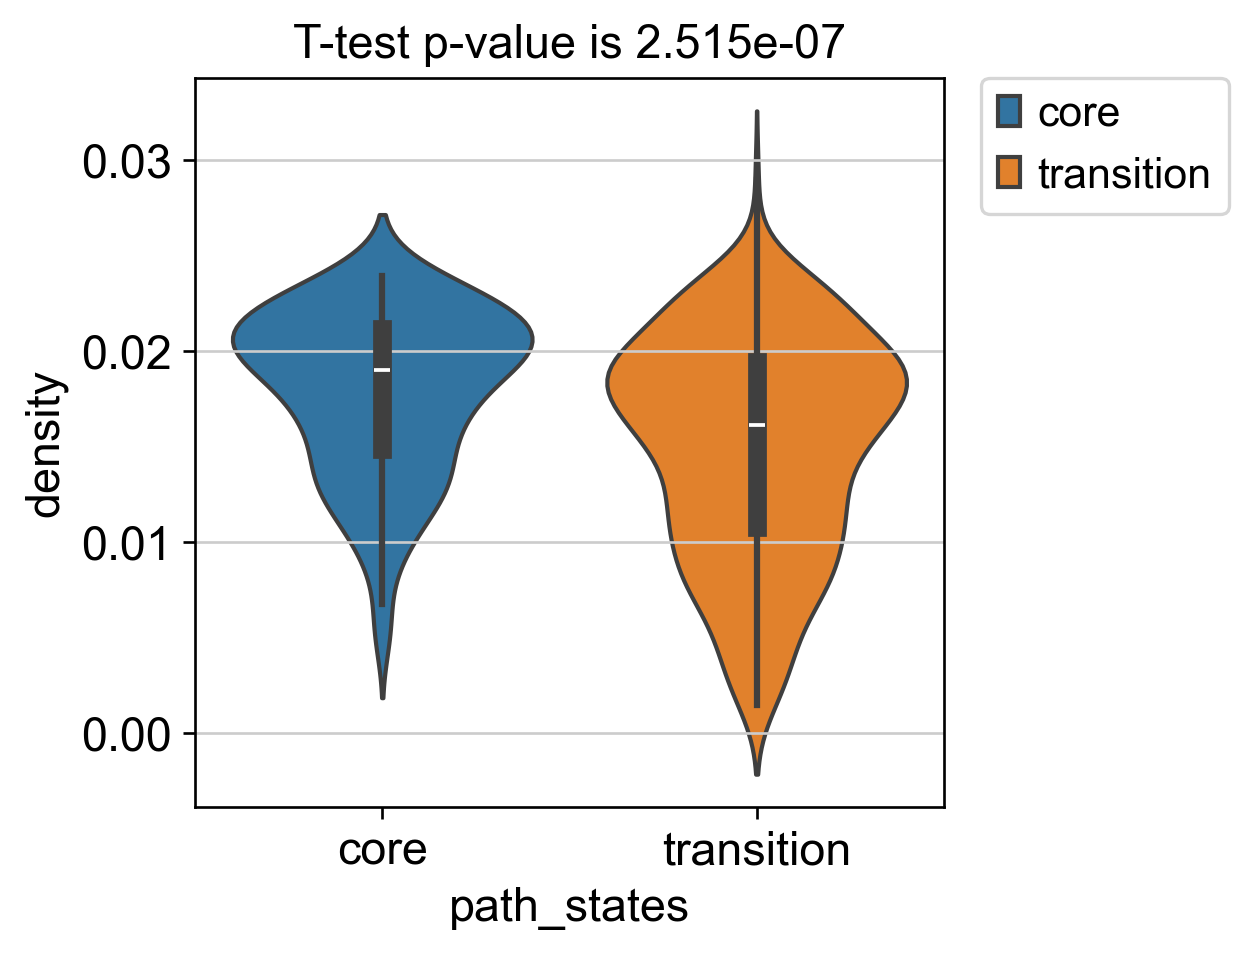

In [119]:
# violin plot to show the density of core states and transition states
from scipy import stats
# t-test for the density of core states and transition states_1
p_val = stats.ttest_ind(adata.obs[adata.obs['path_states']=='core']['density'],
                adata.obs[adata.obs['path_states']=='transition']['density'])[1]
print(f'T-test p-value for core states and transition states_1: {p_val}')

# plot the p_value in the violin plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.violinplot(x ='path_states', y ='density', data = adata.obs, hue='path_states')
# legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# p_value with exponential base 10

plt.title( 'T-test p-value is ' + "{0:.{1}e}".format(p_val, 3))


Differential Gene Variation Analysis

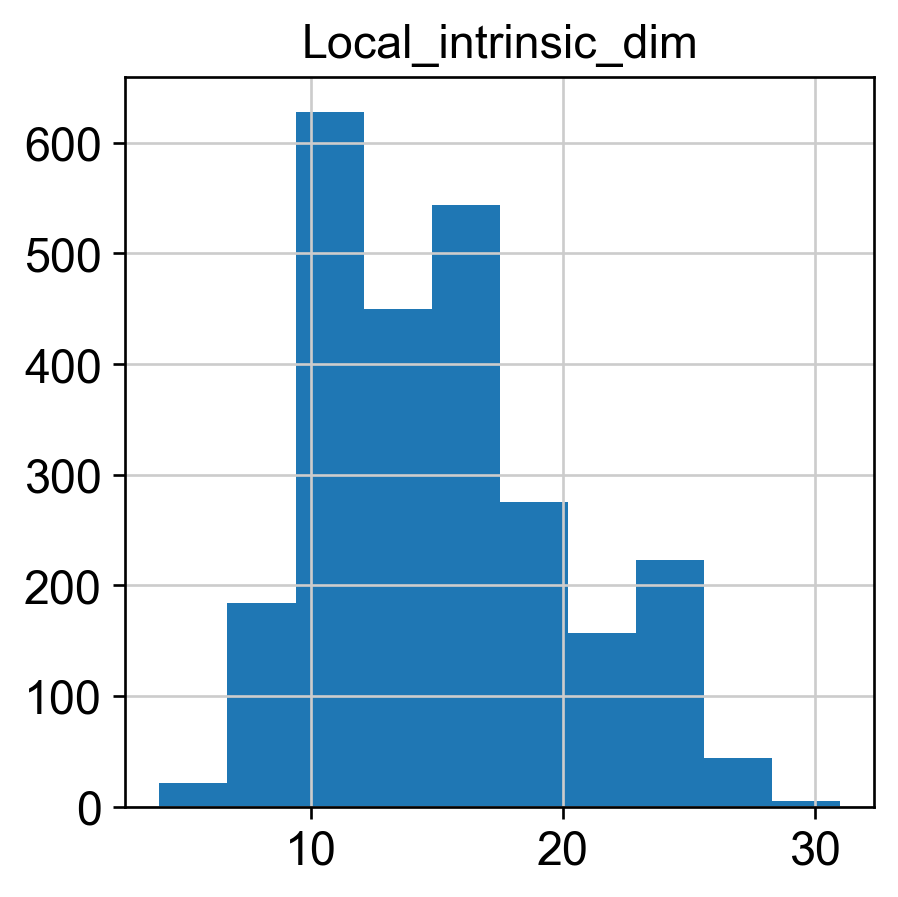

k is 14
Start matrix multiplication
Finish matrix multiplication in 4.5623719692230225
Finish norm calculation in 0.09723711013793945


<Figure size 480x480 with 0 Axes>

In [120]:
importlib.reload(featuremap_)
from featuremap.features import feature_variation, feature_variation_embedding
feature_variation(adata, threshold=0.9)

def variation_feature_pp(adata):
    import anndata as ad
    layer = 'variation_feature'
    adata_var = ad.AnnData(X=adata.layers[layer].copy(), )
    adata_var.obs = adata.obs.copy()
    adata_var.var = adata.var.copy()
    adata_var.layers['counts'] = adata.X.copy() 
    
    adata_var.X[np.isnan(adata_var.X)]=0

    adata_var.obs_names = adata.obs_names
    adata_var.var_names = adata.var_names
    adata_var.obs['clusters'] = adata.obs['clusters'].copy()
    adata_var.layers['counts'] = adata.X.copy()

    # Normalization
    sc.pp.normalize_total(adata_var, target_sum=1e4 )
    sc.pp.log1p(adata_var, )

    # Filtering variation for DGV 
    adata_var.layers['var_filter'] = adata_var.X.copy()
    # Filter low variation
    idx = adata_var.layers['var_filter'] < np.max(adata_var.layers['var_filter']) * 0.2
    # idx = adata_var.layers['var_filter'] < np.quantile(adata_var.layers['var_filter'], 0.2)
    # print(f'Low var ratio is {np.sum(idx) / (idx.shape[0]*idx.shape[1])}')
    adata_var.layers['var_filter'][idx] = 0

    # Filter variation by low count
    if isinstance(adata.X, np.ndarray):
        idx = adata.X < np.max(adata.X) * 0.2
    else:
        idx = adata.X.toarray() < np.max(adata.X.toarray()) * 0.2

    # idx = adata.X.toarray() < np.quantile(adata.X.toarray()[np.nonzero(adata.X.toarray())], 0.2)
    # idx = adata.X < np.max(adata.X) * 0.2
    # print(f'Low var ratio by expression is {np.sum(idx) / (idx.shape[0]*idx.shape[1])}')
    adata_var.layers['var_filter'][idx] = 0
    # Normalization
    sc.pp.normalize_total(adata_var, target_sum=1e4, layer='var_filter' )
    sc.pp.log1p(adata_var, layer='var_filter')

    return adata_var

adata_var = variation_feature_pp(adata)

adata.layers['variation_feature_processed'] = adata_var.layers['var_filter'].copy()


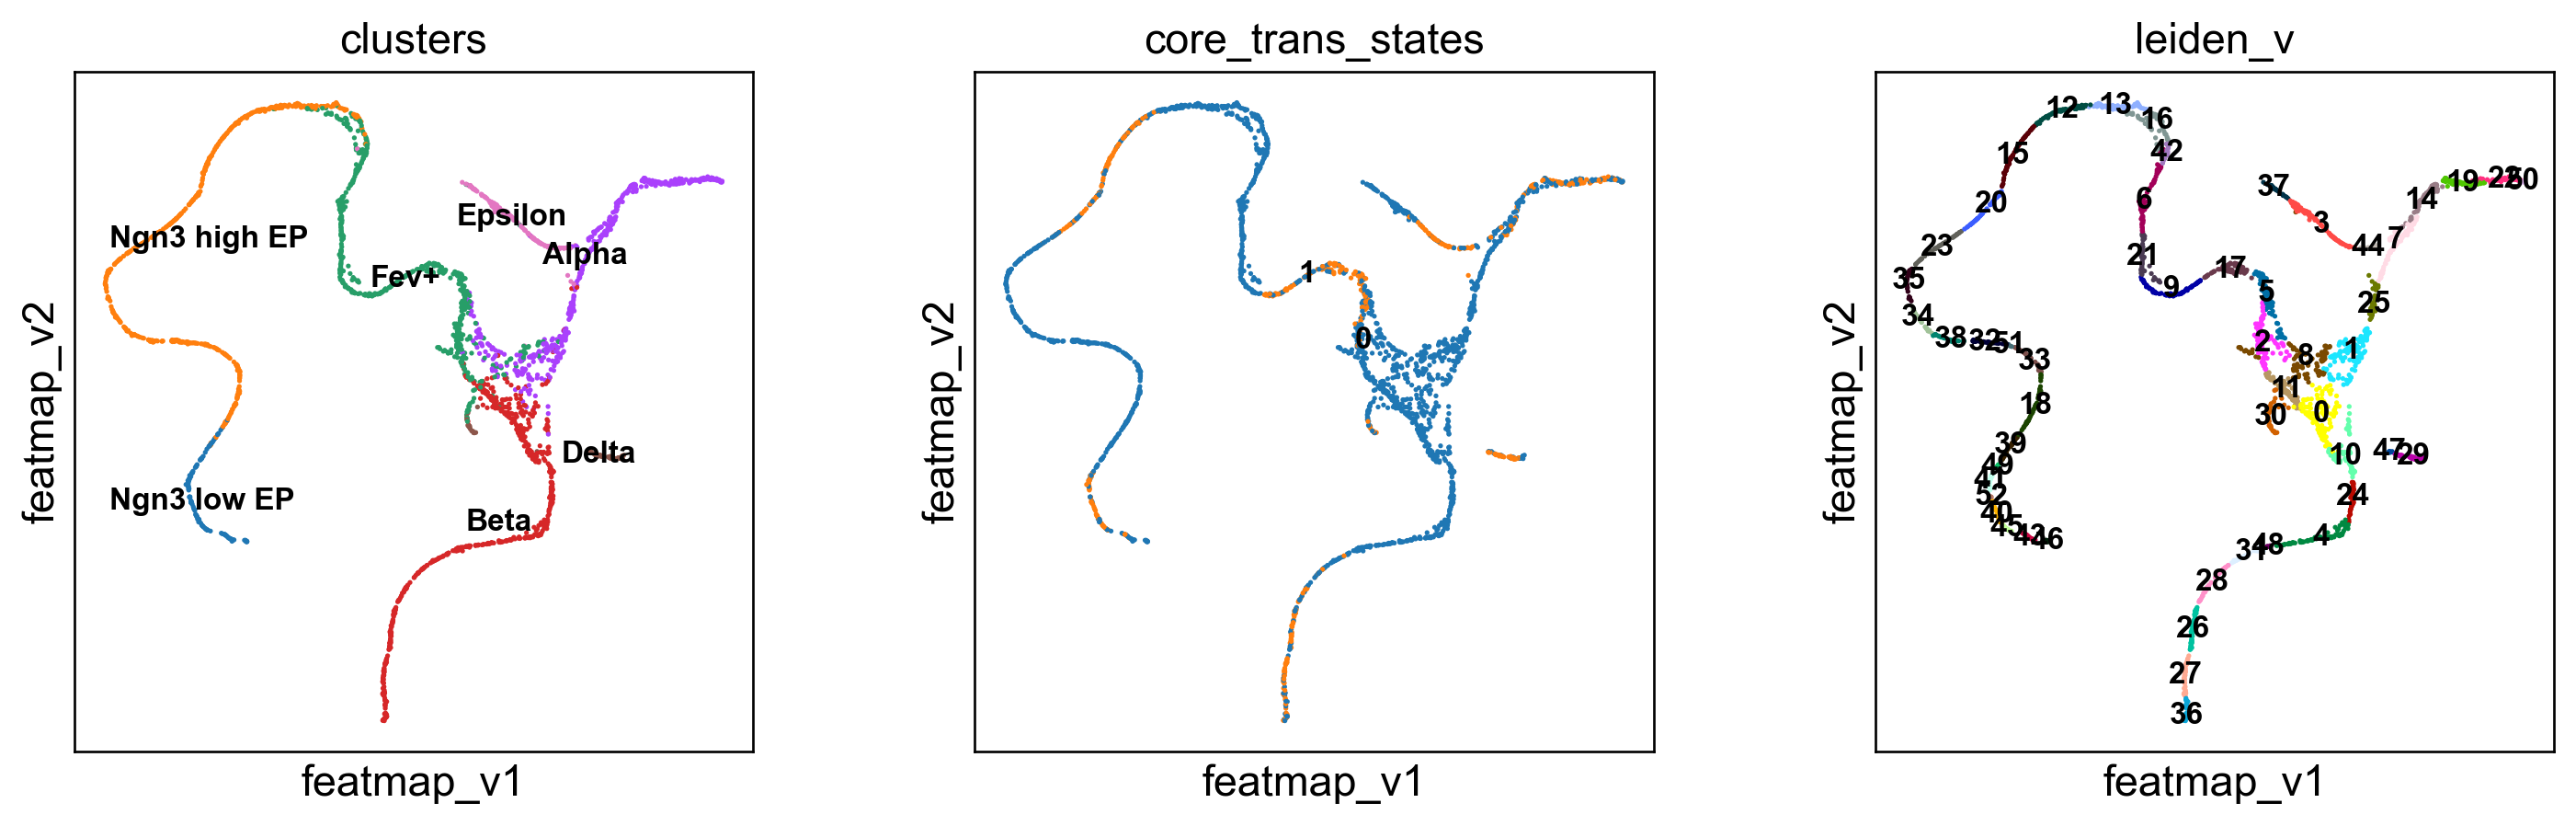

In [121]:
sc.pl.embedding(adata, 'featmap_v',legend_fontsize=10, s=10, legend_loc='on data', 
                color=['clusters','core_trans_states', 'leiden_v'])

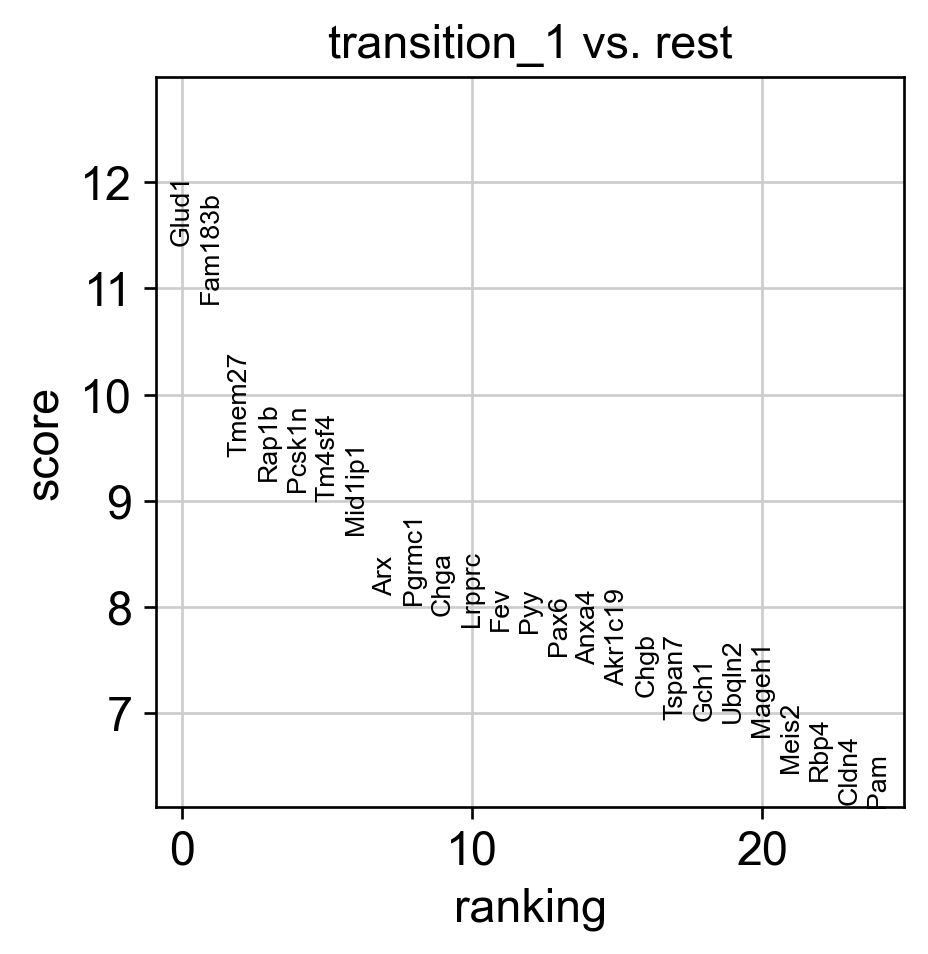

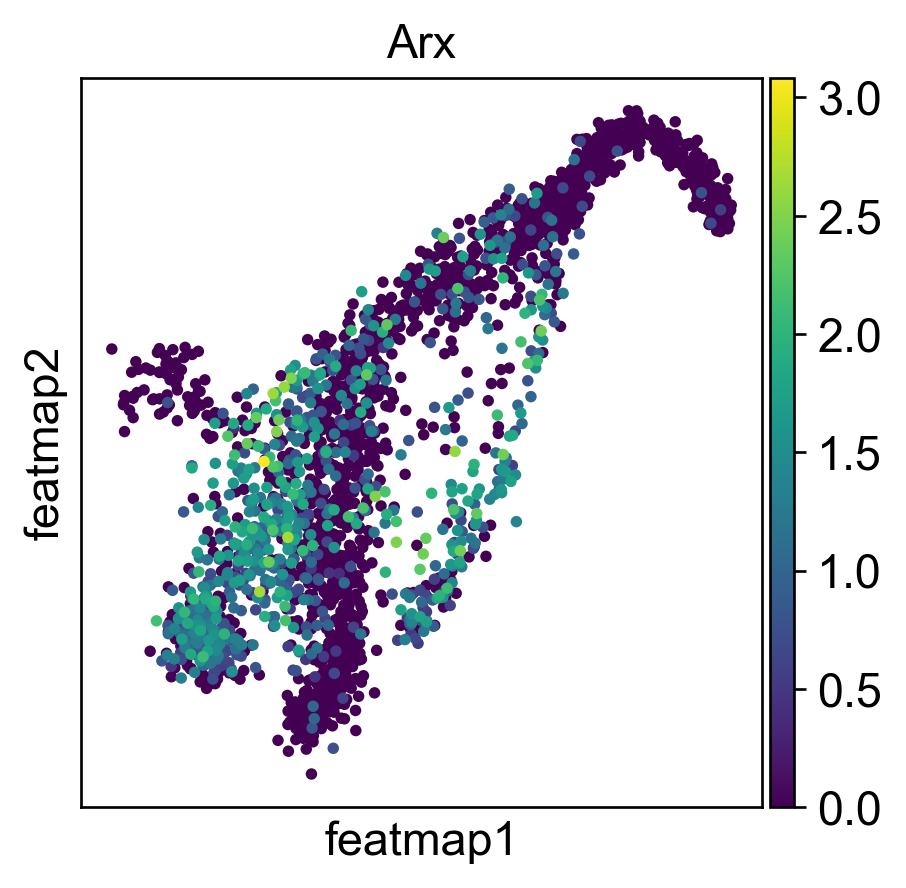

Rank of Arx is  [7] in transition_1
Start matrix multiplication
Finish matrix multiplication in 0.01595282554626465


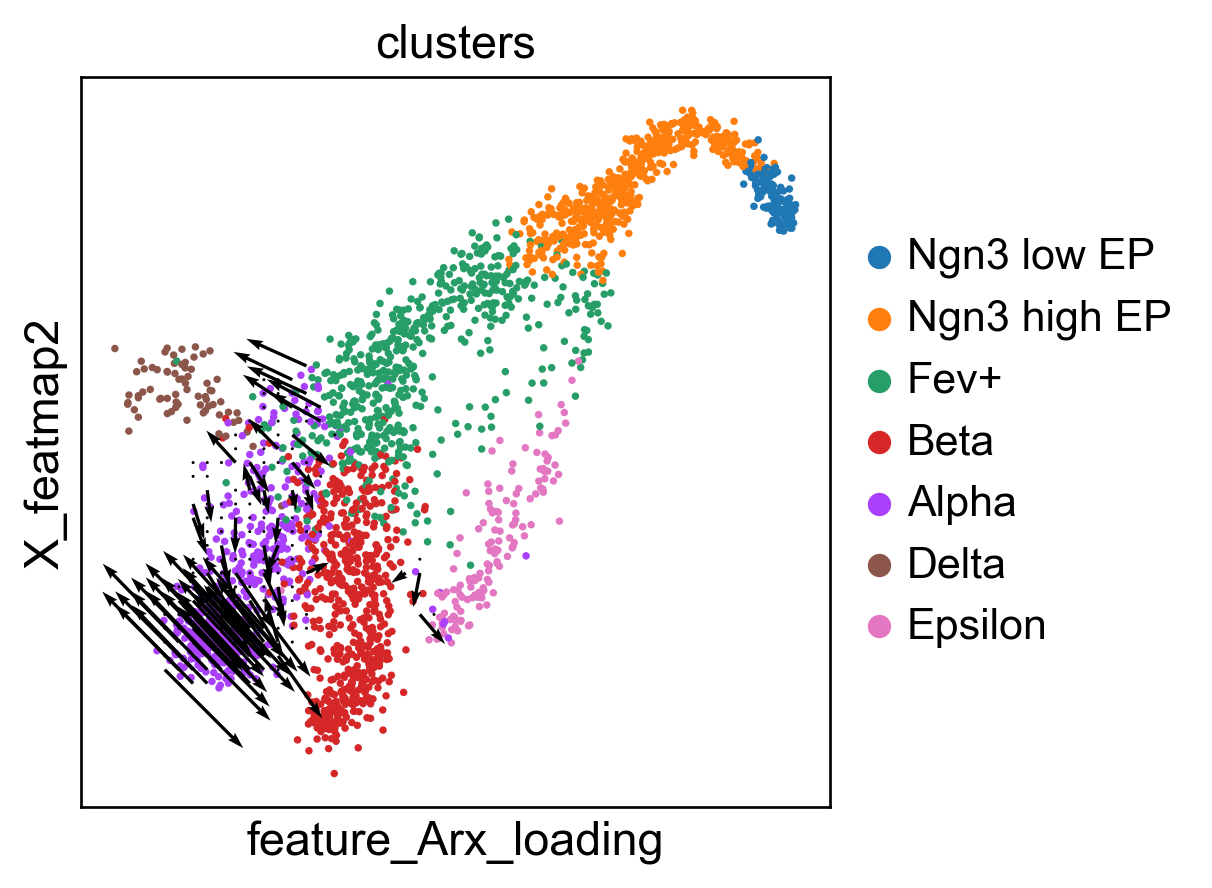

<Figure size 480x480 with 0 Axes>

In [122]:

sc.tl.rank_genes_groups(adata_var, 'core_trans_states_bifur', groups=['transition_1'],  method='wilcoxon', use_raw=False, layer='var_filter')
sc.pl.rank_genes_groups(adata_var, n_genes=25, sharey=False)
# Top 5 genes in rank_genes_groups
top_genes = adata_var.uns['rank_genes_groups']['names']['transition_1'][:5]


gene = 'Arx'
sc.pl.embedding(adata, 'featmap' ,color=[gene],)
rank = np.where(adata_var.uns['rank_genes_groups']['names']['transition_1'] == gene)[0]
print(f'Rank of {gene} is  {rank} in transition_1')

features.feature_projection(adata, feature=gene)
features.plot_one_feature(adata, feature=gene, ratio=0.1, density=1, embedding='X_featmap',
                               pseudotime='feat_pseudotime', pseudotime_adjusted=True, 
                               plot_within_cluster=['Alpha']
                               )    


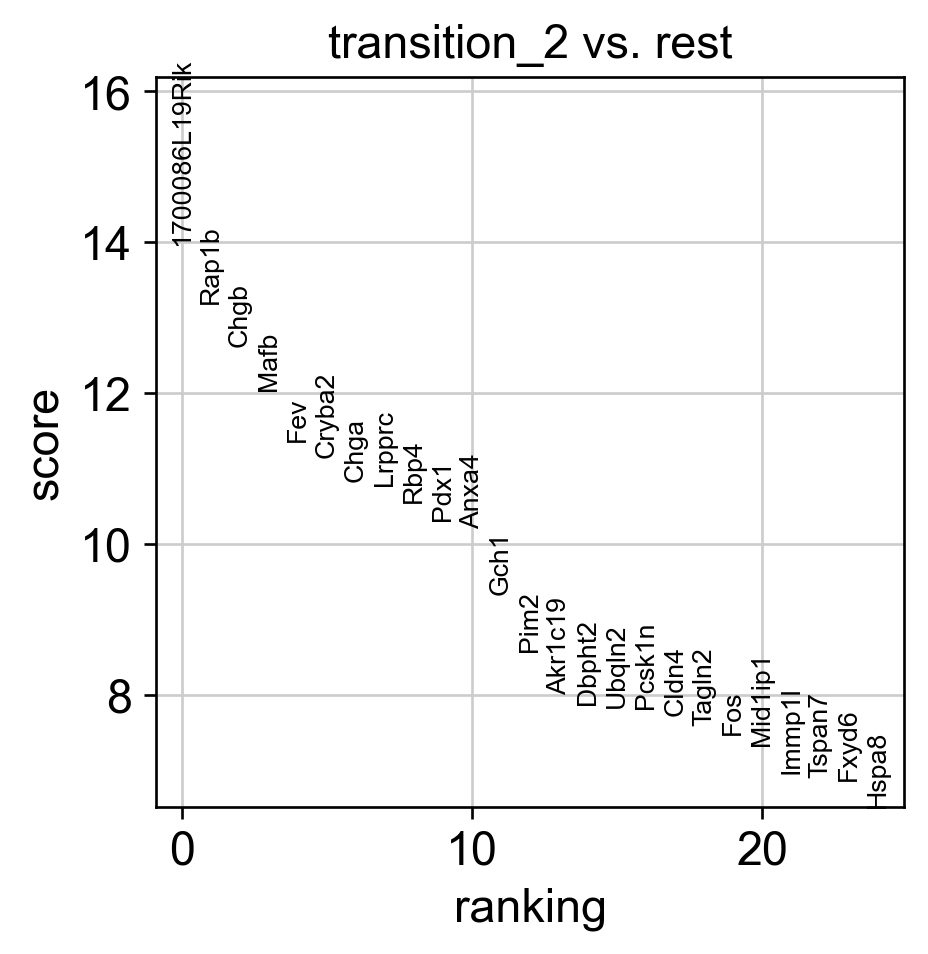

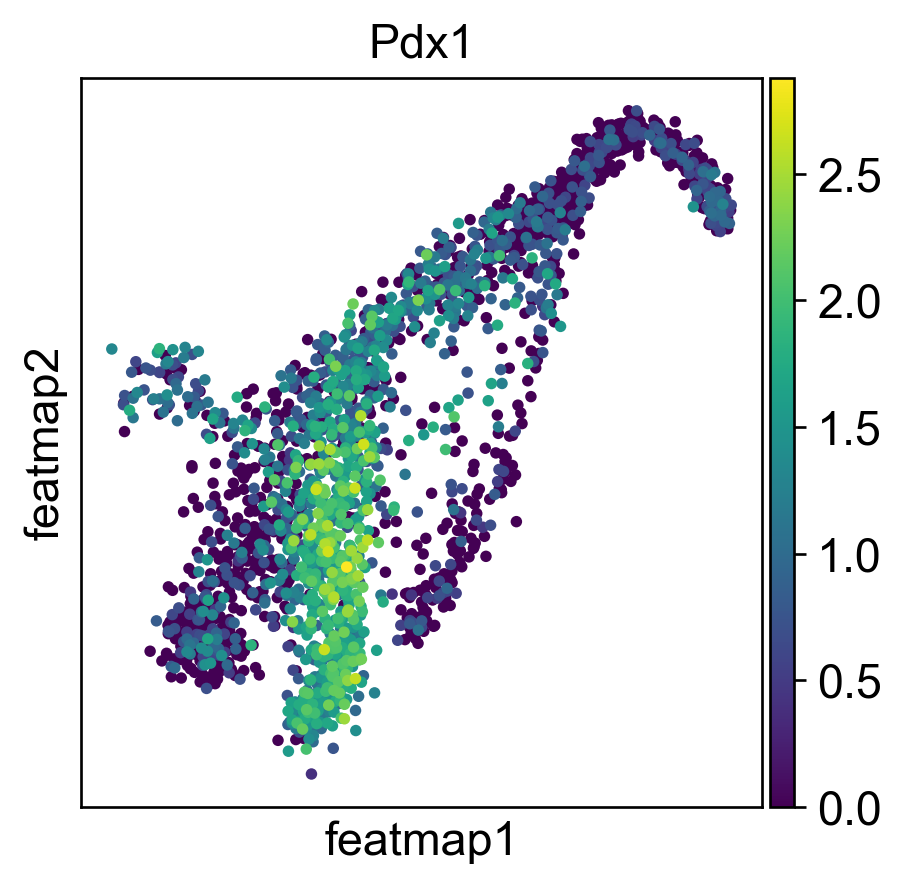

Rank of Pdx1 is  [9] in transition_2
Start matrix multiplication
Finish matrix multiplication in 0.015670061111450195


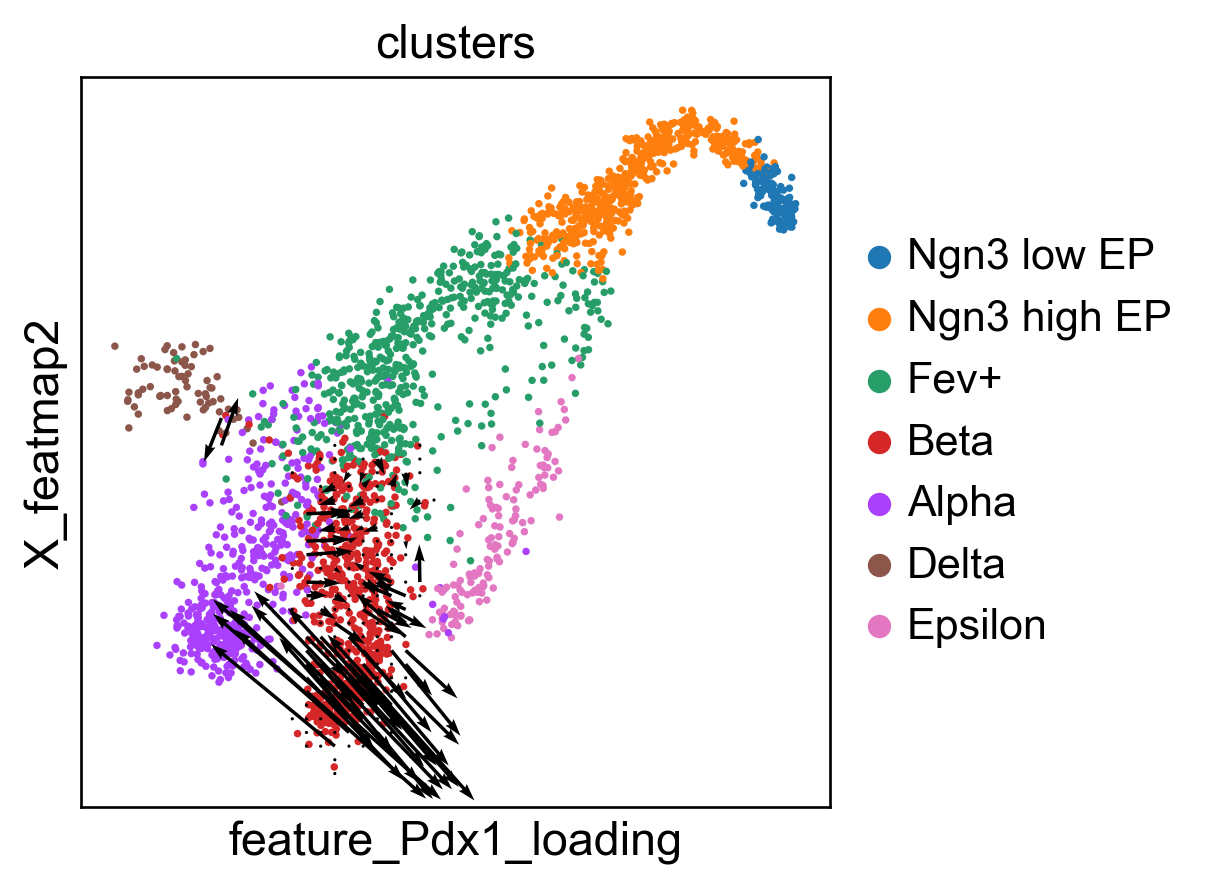

<Figure size 480x480 with 0 Axes>

In [123]:
sc.tl.rank_genes_groups(adata_var, 'core_trans_states_bifur', groups=['transition_2'],  method='wilcoxon', use_raw=False, layer='var_filter')
sc.pl.rank_genes_groups(adata_var, n_genes=25, sharey=False)
# Top 5 genes in rank_genes_groups
top_genes = adata_var.uns['rank_genes_groups']['names']['transition_2'][:5]

gene = 'Pdx1'
sc.pl.embedding(adata, 'featmap' ,color=[gene],)
rank = np.where(adata_var.uns['rank_genes_groups']['names']['transition_2'] == gene)[0]
print(f'Rank of {gene} is  {rank} in transition_2')

features.feature_projection(adata, feature=gene)
features.plot_one_feature(adata, feature=gene, ratio=0.1, density=1, embedding='X_featmap',
                               pseudotime='feat_pseudotime', pseudotime_adjusted=True, 
                               plot_within_cluster=['Beta',]
                               )    



In [124]:
adata


AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'n_genes', 'feat_pseudotime', 'density', 'density_separate_cluster', 'corestates', 'corestates_largest', 'corestates_binary', 'corestates_points', 'core_trans_states', 'cell_variation', 'leiden_v', 'core_trans_states_bifur', 'path_states', 'intrinsic_dim'
    var: 'highly_variable_genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'corestates_colors', 'core_trans_states_colors', 'leiden_v_colors', 'core_trans_states_bifur_colors', 'path_states_colors'
    obsm: 'X_featmap', '_knn_indices', 'U', 'Singular_value', 'VH', 'vh_smoothed', 'gauge_v1_emb', 'gauge_v2_emb', 'VH_embedding', 'R', 'mu_sum', 're_sum', 're_sum_without_log', 'emb_knn_indices', 'X_embedding', 'X_featmap_v', 'variation_pc', 'X_featmap_v_3d'
    var

In [125]:
# from featuremap import features

# import importlib
# importlib.reload(features)
# top_genes =  adata_var.uns['rank_genes_groups']['names']['transition'][:10]
# feature = top_genes
# for f in feature:
#     print(f'Plotting {f}...')
#     features.feature_projection(adata, feature=f)
#     features.plot_one_feature(adata, feature=f, ratio=0.1, density=1, embedding='X_featmap',
#                                pseudotime='feat_pseudotime', pseudotime_adjusted=False, 
#                             #    plot_within_cluster=['Delta', ]
#                                )    


In [126]:

# import importlib
# importlib.reload(features)

# features.plot_gauge_both(adata)